In [16]:
import pandas as pd
from dp_transformer import DifferentialPrivacyTransformer
import numpy as np
import pandas as pd
from dp_mechanisms.quantitative import (
    duchi_mechanism,
    piecewise_mechanism,
    normalize_to_range,
    denormalize_from_range,
    laplace_mechanism,
    multidimensional_duchi_mechanism,
    multidimensional_mechanism
)
from dp_mechanisms.categorical import direct_encoding, optimized_unary_encoding, rappor
from dp_plotting import plot_mean_vs_privatized, plot_histograms
import torch

What we do, was to create the algorithms of differential privacy. Now my job is to try how this algorithms are working, see the changes in distribution, and try to understand them. We are going to do a simple analisis of two methods and their corresponding data.


In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn.metrics import mean_squared_error

# Load the CSV file into a DataFrame
file_path = r"C:\Users\David\Universidad de los andes\David Stiven Romero Grajales - Trabajo de Grado\Trabajo de Grado 1\Base de datos y descripción\Entrenamiento_cronicas_N.csv"
df_final = pd.read_csv(file_path)

df_final.rename(columns={'Edad': 'Age'}, inplace=True)

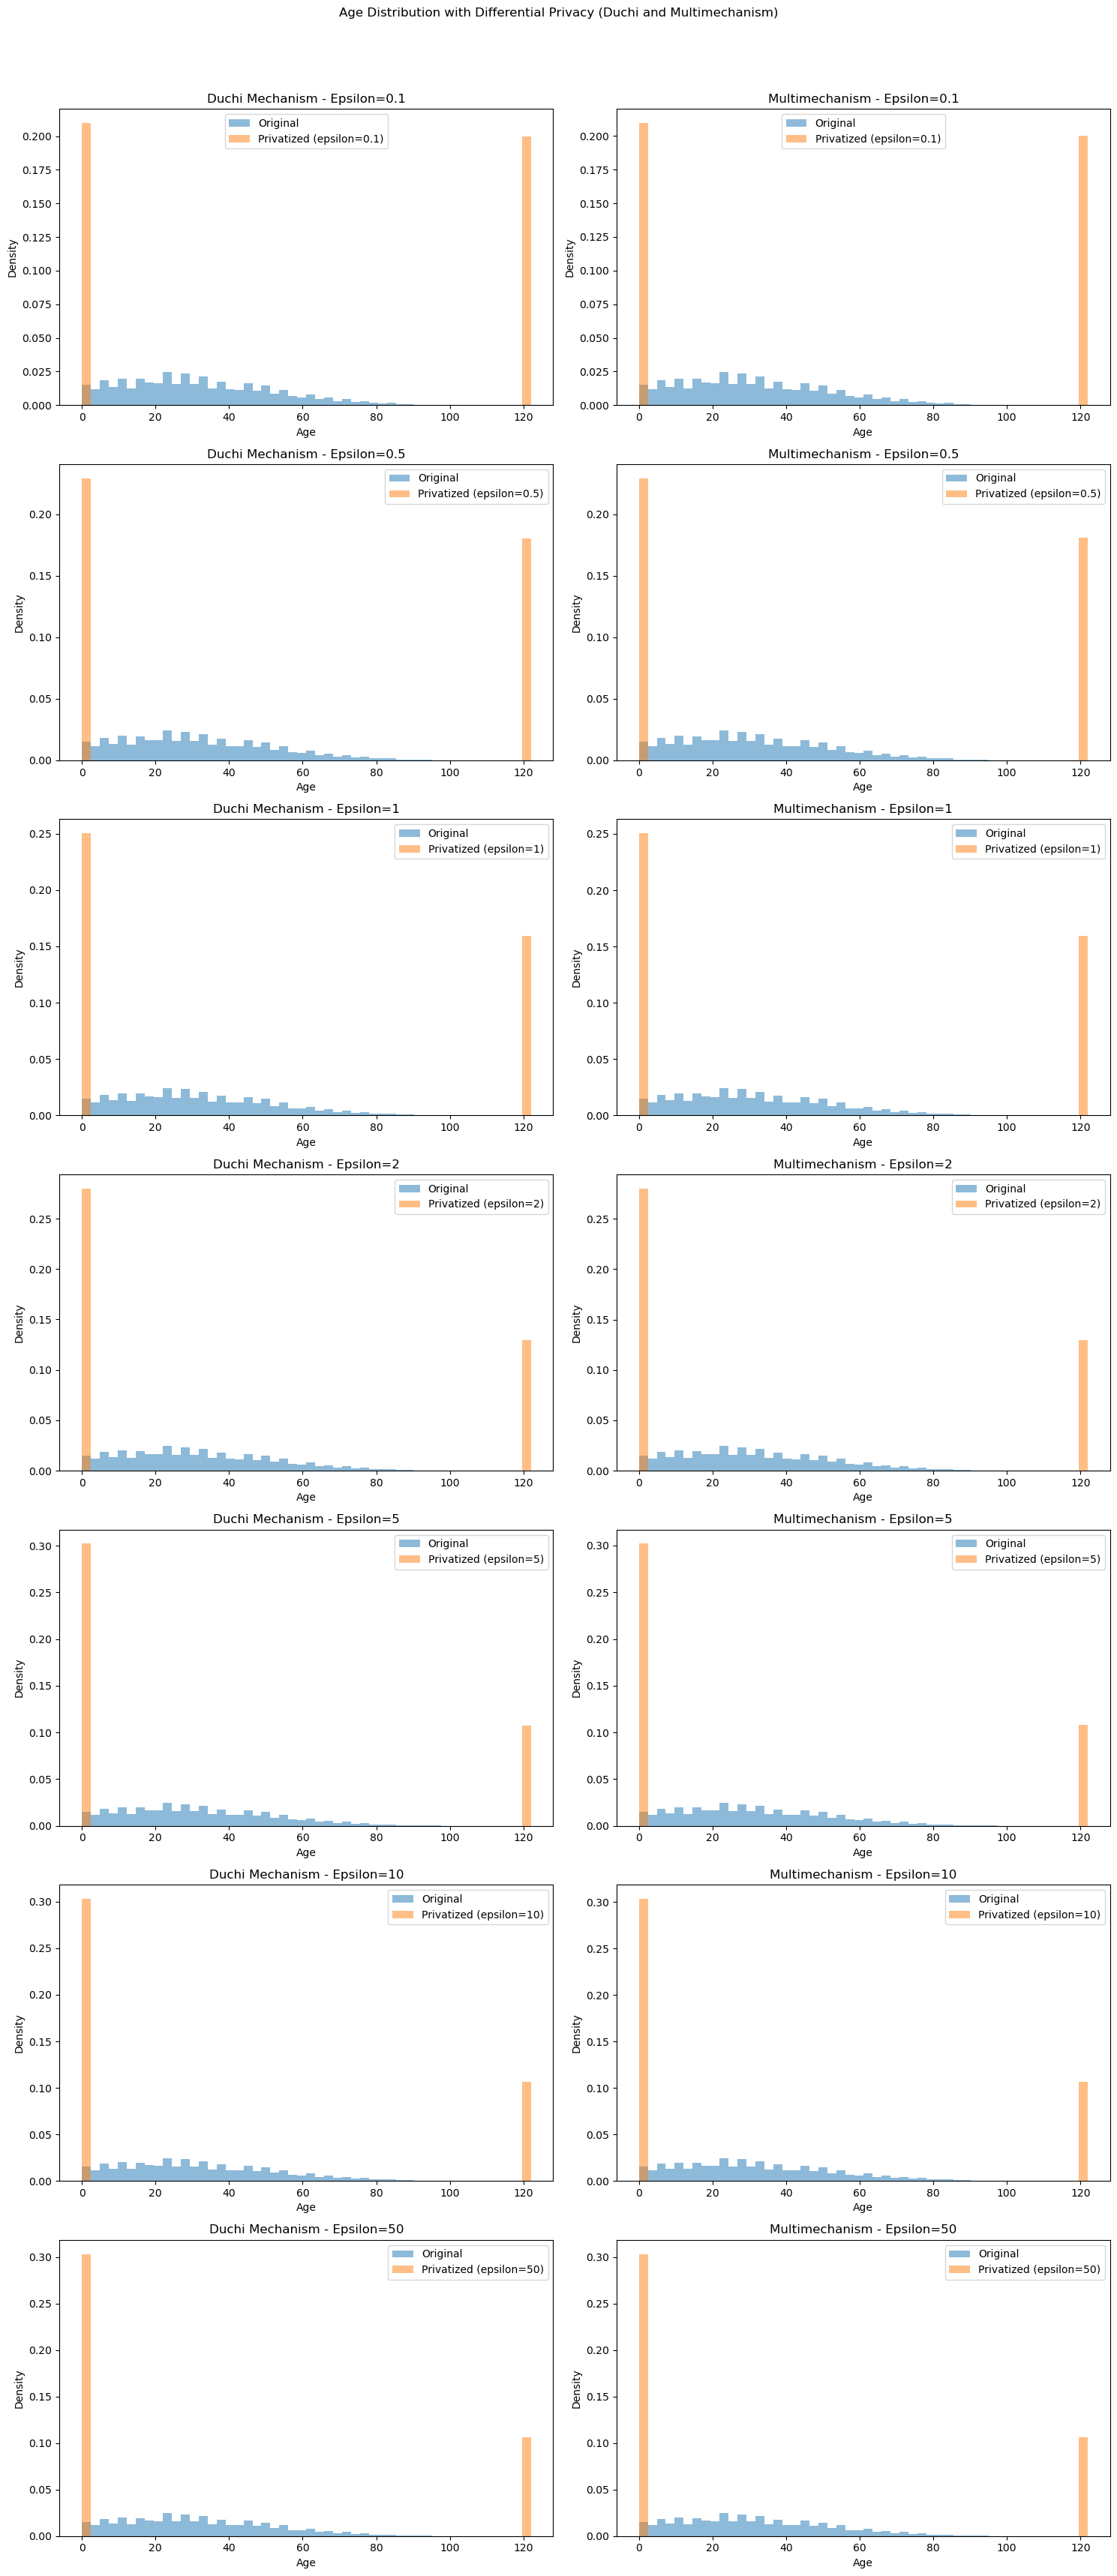

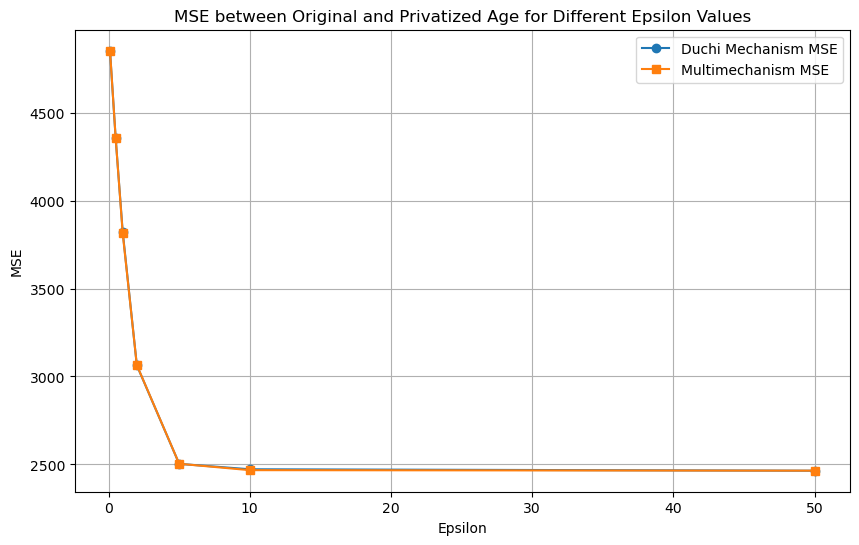

In [31]:
# Check if 'Age' is in df_final
if 'Age' not in df_final.columns:
    raise ValueError("Column 'Age' is not present in df_final.")

# Extract and normalize the 'Age' column
age_original = df_final['Age'].copy()
age_tensor = torch.tensor(age_original.values, dtype=torch.float32)
age_normalized, min_val, max_val = normalize_to_range(age_tensor)

# Define a range of epsilon values to test
epsilon_values = [0.1, 0.5, 1, 2, 5, 10, 50]
mse_values_duchi = []
mse_values_multimechanism = []

# Initialize a figure for histograms
fig, axs = plt.subplots(len(epsilon_values), 2, figsize=(15, 5 * len(epsilon_values)))
fig.suptitle("Age Distribution with Differential Privacy (Duchi and Multimechanism)")

for idx, epsilon in enumerate(epsilon_values):
    # Apply multidimensional_duchi_mechanism to normalized 'Age' with the current epsilon
    age_priv_duchi = multidimensional_duchi_mechanism(age_normalized.unsqueeze(1), epsilon, B=1.0).squeeze()
    # Denormalize back to original range
    age_priv_duchi_denorm = age_priv_duchi * (max_val - min_val) / 2 + (max_val + min_val) / 2
    mse_duchi = mean_squared_error(age_original, age_priv_duchi_denorm)
    mse_values_duchi.append(mse_duchi)
    
    # Apply multidimensional_mechanism to normalized 'Age' with the current epsilon
    age_priv_multi = multidimensional_mechanism(age_normalized.unsqueeze(1), epsilon, mechanism='duchi', C=1.0).squeeze()
    # Denormalize back to original range
    age_priv_multi_denorm = age_priv_multi * (max_val - min_val) / 2 + (max_val + min_val) / 2
    mse_multi = mean_squared_error(age_original, age_priv_multi_denorm)
    mse_values_multimechanism.append(mse_multi)
    
    # Plot histogram for Duchi mechanism
    axs[idx, 0].hist(age_original, bins=50, alpha=0.5, label='Original', density=True)
    axs[idx, 0].hist(age_priv_duchi_denorm.numpy(), bins=50, alpha=0.5, label=f'Privatized (epsilon={epsilon})', density=True)
    axs[idx, 0].set_title(f'Duchi Mechanism - Epsilon={epsilon}')
    axs[idx, 0].set_xlabel('Age')
    axs[idx, 0].set_ylabel('Density')
    axs[idx, 0].legend()
    
    # Plot histogram for Multimechanism
    axs[idx, 1].hist(age_original, bins=50, alpha=0.5, label='Original', density=True)
    axs[idx, 1].hist(age_priv_multi_denorm.numpy(), bins=50, alpha=0.5, label=f'Privatized (epsilon={epsilon})', density=True)
    axs[idx, 1].set_title(f'Multimechanism - Epsilon={epsilon}')
    axs[idx, 1].set_xlabel('Age')
    axs[idx, 1].set_ylabel('Density')
    axs[idx, 1].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Plot MSE vs Epsilon for both mechanisms
plt.figure(figsize=(10, 6))
plt.plot(epsilon_values, mse_values_duchi, marker='o', label='Duchi Mechanism MSE')
plt.plot(epsilon_values, mse_values_multimechanism, marker='s', label='Multimechanism MSE')
plt.title('MSE between Original and Privatized Age for Different Epsilon Values')
plt.xlabel('Epsilon')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()